# Imports and Initialisation

In [21]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.optim as optim

In [22]:
# Preprocessing
trainTransform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5]*3, std = [0.5]*3)])

In [23]:
#Validation transform
valTransform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5]*3, std = [0.5]*3)
])

In [24]:
# Generating dataset
class GalaxyDataset(Dataset):
    def __init__(self, csvfile, imgDir, transform=None):
        self.data = pd.read_csv(csvfile)  # Use the passed csvfile name
        self.imgDir = imgDir
        self.transform = transform

        # Setting up the labels
        self.labels = self.data[['SPIRAL', 'ELLIPTICAL', 'UNCERTAIN']].values.argmax(axis=1)
        self.imageNames = self.data['asset_id'].astype(str) + '.jpg'

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        imgPath = os.path.join(self.imgDir, self.imageNames.iloc[idx])  # fixed typo here
        image = Image.open(imgPath).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Checking for missing images

In [25]:
allAssets = pd.read_csv("train.csv")
allImageNames = allAssets['asset_id'].astype(str) + '.jpg'

imageDir = 'train_images'

# Check which files are missing
missingImages = [img for img in allImageNames if not os.path.exists(os.path.join(imageDir, img))]

# Report
if not missingImages:
    print("All images found in train_images!")
else:
    print(f"Missing {len(missingImages)} images:")
    for img in missingImages:
        print(img)

Missing 3 images:
169.jpg
374.jpg
560.jpg


In [26]:
missingAssets = [asset.split('.',1)[0] for asset in missingImages]
missingAssets



['169', '374', '560']

# Training and validation split

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
fullData = pd.read_csv("train.csv")

#removing data with no corresponding images
fullData = fullData[~fullData['asset_id'].astype(str).isin(missingAssets)]

trainData, valData = train_test_split(fullData, test_size=0.2, random_state=69)

trainData.to_csv('train_split.csv', index=False)
valData.to_csv('val_split.csv', index=False)

In [29]:
#creating dataset objects
trainDataset = GalaxyDataset('train_split.csv', 'train_images', transform=trainTransform)
valDataset = GalaxyDataset('val_split.csv', 'train_images', transform=valTransform)

In [30]:
#creating dataloaders
trainLoader = DataLoader(trainDataset, batch_size=32, shuffle=True)
valLoader = DataLoader(valDataset, batch_size=32, shuffle=False)

In [31]:
#testing
images, labels = next(iter(trainLoader))
print(images.shape)  # Should be [32, 3, 224, 224]
print(labels.shape)  # Should be [32]

torch.Size([32, 3, 128, 128])
torch.Size([32])


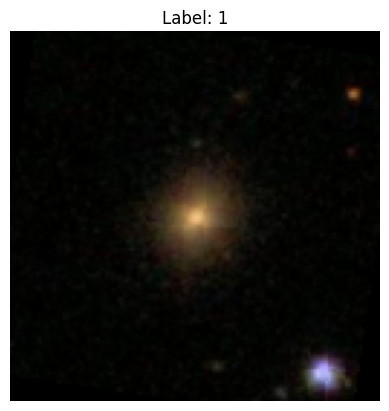

In [32]:
testImg = images[0]  # shape: [3, 224, 224]
testImg = testImg.permute(1, 2, 0).numpy()  # to shape [224, 224, 3]

testImg = testImg * 0.5 + 0.5  # unnormalize to [0, 1] range

plt.imshow(testImg)
plt.title(f"Label: {labels[0].item()}")
plt.axis('off')
plt.show()

# Importing Resnet18

In [33]:
import torchvision.models as models
import torch.nn as nn

In [34]:
model = models.resnet18(pretrained=True)

c:\Users\Divyansh Sharma\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Divyansh Sharma\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


This block is subject to change

In [35]:
for param in model.parameters():
    param.requires_grad = False

In [36]:
#change last layer to have only 3 outputs
numFeatures = model.fc.in_features
model.fc = nn.Linear(numFeatures, 3)

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [38]:
#testing torch version
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

2.6.0+cu118
True
NVIDIA GeForce RTX 3050 6GB Laptop GPU


In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Training Loop

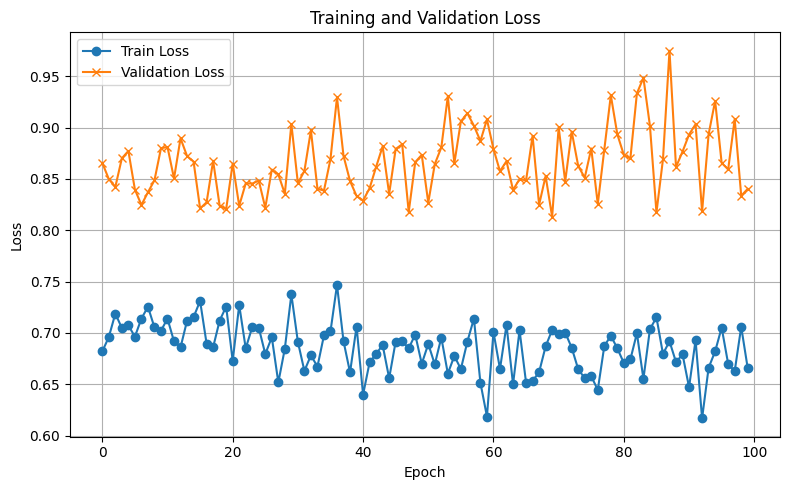

In [ ]:
numEpochs = 100

#For plotting
trainLosses = []
valLosses = []

# Early stopping variables
bestValLoss = float('inf')
bestModelState = None
patience = 5
epochsNoImprove = 0

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)


for epoch in range(numEpochs):
    model.train()
    runningTrainLoss = 0

    #train loop
    for images, labels in trainLoader:
        images, labels = images.to(device), labels.to(device) #move to GPU

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        runningTrainLoss += loss.item()

    
    avgTrainLoss = runningTrainLoss / len(trainLoader)
    trainLosses.append(avgTrainLoss)

    #validation loop

    model.eval()
    runningValLoss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in valLoader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            runningValLoss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avgValLoss = runningValLoss / len(valLoader)
    valAccuracy = 100 * correct / total
    valLosses.append(avgValLoss)

    print(f"Epoch {epoch+1}/{numEpochs} | Train Loss: {avgTrainLoss:.4f} | Val Loss: {avgValLoss:.4f} | Val Accuracy: {valAccuracy:.2f}%")

    # Step the scheduler
    scheduler.step(avgValLoss)

    # Early stopping logic
    if avgValLoss < bestValLoss:
        bestValLoss = avgValLoss
        bestModelState = model.state_dict()
        epochsNoImprove = 0
    else:
        epochsNoImprove += 1
        if epochsNoImprove == patience:
            print(f"\nEarly stopping at epoch {epoch + 1}")
            break

# Restore best model
if bestModelState:
    model.load_state_dict(bestModelState)

bestEpoch = valLosses.index(min(valLosses))

torch.save(bestModelState, "best_model.pth")

plt.figure(figsize=(8, 5))
plt.plot(trainLosses, label='Train Loss', marker='o')
plt.plot(valLosses, label='Validation Loss', marker='x')
plt.axvline(bestEpoch, color='red', linestyle='--', label=f'Best Epoch ({bestEpoch})')  # vertical line
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\nBest Epoch: {bestEpoch + 1} | Best Val Loss: {bestValLoss:.4f}")